In [ ]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [27]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

In [28]:
df = pd.read_csv(
    "/home/jovyan/work/training_data/sw_training_data.csv", 
    parse_dates=['read_date'], 
    index_col="read_date"
    )

df = df.drop(['bl_meter1','bl_meter2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

dataset = df.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [29]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [30]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [31]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
# create and fit the LSTM network
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(trainX.shape[1], trainX.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
history = model.fit(
    trainX, trainY, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
100/100 [==============================] - 4s 9ms/step - loss: 0.0014 - val_loss: 2.5895e-05
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 7.9493e-04 - val_loss: 1.3128e-05
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 6.4599e-04 - val_loss: 6.4813e-07
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 4.8780e-04 - val_loss: 1.5612e-05
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 3.8130e-04 - val_loss: 1.9094e-05
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 3.1243e-04 - val_loss: 7.8373e-06
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 3.0655e-04 - val_loss: 3.6267e-06
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 2.9926e-04 - val_loss: 8.2896e-07
Epoch 9/30
100/100 [==============================] - 0s 4ms/step - loss: 2.9701e-04 - val_loss: 2.0459e-06
Epoch 10/30
100/100 [===========

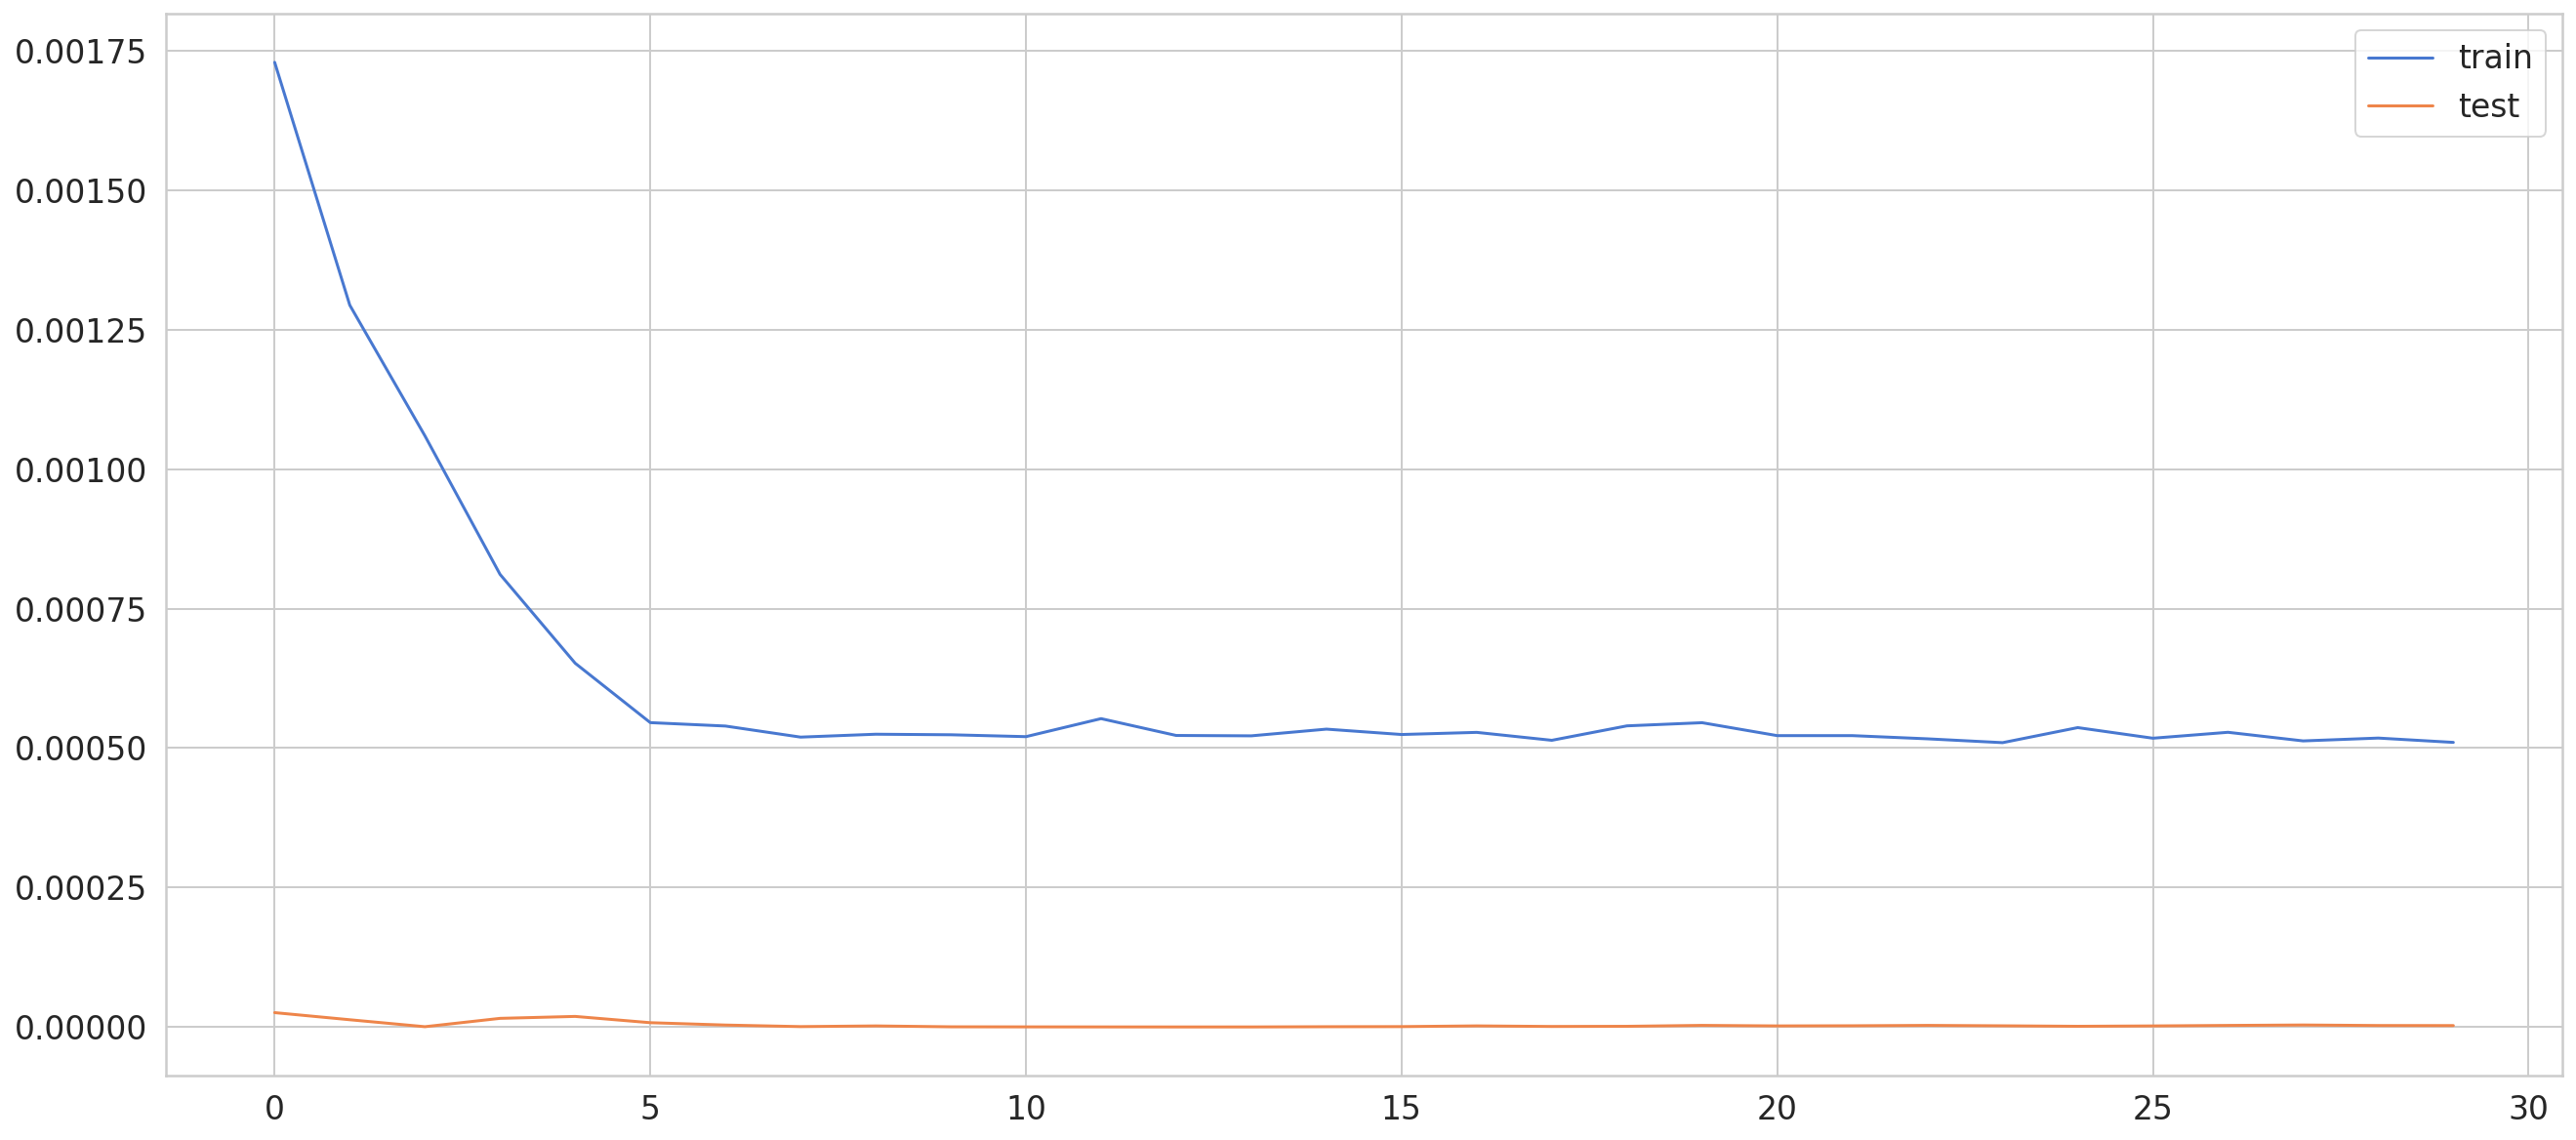

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [48]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [47]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])


ValueError: non-broadcastable output operand with shape (3546,1) doesn't match the broadcast shape (3546,6)

In [36]:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

ValueError: operands could not be broadcast together with shapes (1747,3) (6,) (1747,3) 

In [37]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

NameError: name 'math' is not defined

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()